# Домашнее задание №1 - Применение методов NLP


В этом домашнем задании мы будем работать с данными из сорневнования: 
[Toxic comment classification challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)
  
  
В задании небходимо по тексту комментария определить веротяности следующих категорий:
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

Как и в соревновании мы везде будем использовать метрику ROC AUC для валидации

_Обратите внимание, что каждый комментарий может иметь несколько меток разных классов_

### Что нужно сделать? 

1. Подготовка __[10%]__:
    - Скачайте данные, проведите первоначальные EDA: баланс классов, пересечение классов и т.д. 
    - Придумайте и обоснуйте стратегию валидации. 
    - Сделайте предбработку данных. Оцените что требуется делать с символами, заглавными буквами. Проведите лемматизацию или стеминг.
2. Примените любой Embedding (word2vec или Glove) __[5%]__
3. Постройте следующие модели (для каждой необходимо самостоятельно выбрать оптимальное количество слоеев и архитектуру, оценить качество, переобученность, построить кривые обучения и валидации, сделать выводы по примению модели):
    - Одномерные свертки __[20%]__
    - LSTM или GRU __[20%]__
    - Bidirectional LSTM __[20%]__   
4. Попробуйте применить к этой задаче BERT или GPT-2. Выбор оптимального количества слоеев и архитектура на ваш вкус (но не забудьте обосновать его). Оцените качетво и другие параметры работы модели. __[25%]__

#### Дополнительные 50%

5. Основываясь на полученных результатах, сделайте свою лучшую модель и сделайте Late Submission на тестовых данных [challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Не забудьте <u>приложить</u> скриншот с Вашим скором. Скриншот вставьте прямо в ноутбук с решением или выведите в stdout. 

  
  
______
_Правила полученения дополнительных баллов:_
- можно получить от 20% до 50% в зависимости от метрики качества других участников нашего курса полученного на лидерборде
- Чтобы получить минимум в 20% нужно: 
    - Основные задания должны быть полностью решены
    - Обосновать то решение которое отправили.
    - Предложенная модель должна отличаться от тех, что строились в заданиях 2-4
    
__ Готовый ноутбук загрузите в эту форму: [http://bit.ly/dafe_hw](http://bit.ly/dafe_hw) __


______

# Оглавление

## 1. Подготовка
   * ### 1.1 [EDA](#1.1-EDA)
   * ### 1.2 [Стратегия Валидации](#1.2-Стратегия-Валидации)
   * ### 1.3 [Предобработка Данных](#1.3-Предобработка-Данных)
   
## 2. Embedding
   * ### 2.1 [Applying](#2.1-Applying)
   
## 3. Models
   * ### 3.1 [CNN-1D](#3.1-CNN-1D)
      * #### 3.1.1 Model
      * #### 3.1.2 Training
      * #### 3.1.3 Conclusion
   * ### 3.2 [LSTM](#3.2-LSTM)
      * #### 3.2.1 Model
      * #### 3.2.2 Training
      * #### 3.2.3 Conclusion
   * ### 3.3 [Bi-LSTM](#3.3-Bi-LSTM)
      * #### 3.3.1 Model
      * #### 3.3.2 Training
      * #### 3.3.3 Conclusion
      
## 4. BERT
   * ### 4.1 [Model Prepearing](#4.1-Model-Prepearing)
   * ### 4.2 [Training](#4.2-Training)
   * ### 4.3 [Conclusion](#4.3-Conclusion)
   
## 5. Try Hard
   * ### 5.1 [Model Prepearing](#5.1-Model-Prepearing)
   * ### 5.2 [Train](#5.2-Train)
   * ### 5.3 [Submission Creation](#5.3-Submission-Creation)
______

# 1. Подготовка 

## 1.1 EDA

In [1]:
import pandas as pd 
import numpy as np

import gc
import time
import warnings

from scipy import sparse
import scipy.stats as ss

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from PIL import Image
import matplotlib_venn as venn

import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
# import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer

from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from keras.models import Model
from keras.layers import Input, Dense, Embedding, MaxPooling1D, Conv1D, SpatialDropout1D
from keras.layers import add, Dropout, PReLU, BatchNormalization, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import optimizers
from keras import initializers, regularizers, constraints, callbacks

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, concatenate
from keras.layers import LSTM, Bidirectional, LeakyReLU, CuDNNGRU, CuDNNLSTM, SpatialDropout1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

sns.set_style("whitegrid")
np.random.seed(0)

color = sns.color_palette()
sns.set_style("dark")
warnings.filterwarnings("ignore")

%matplotlib inline

Using TensorFlow backend.


In [57]:
train=pd.read_csv("input/jigsaw-toxic-comment-classification-challenge/train.csv")
test=pd.read_csv("input/jigsaw-toxic-comment-classification-challenge/test.csv")

In [58]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [59]:
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 159571 : 153164
perc   : 51    : 49


In [60]:
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


In [61]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


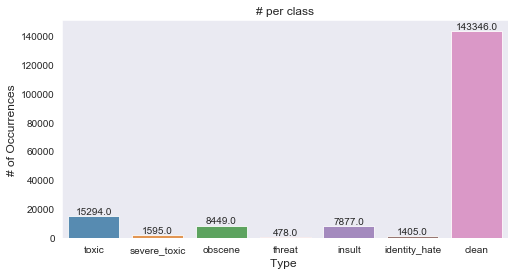

In [62]:
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

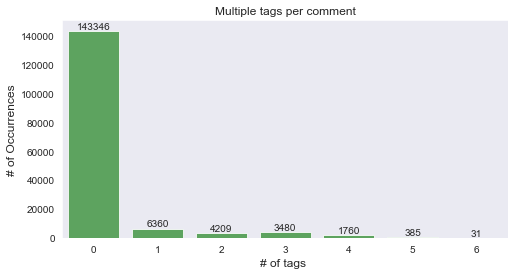

In [63]:
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

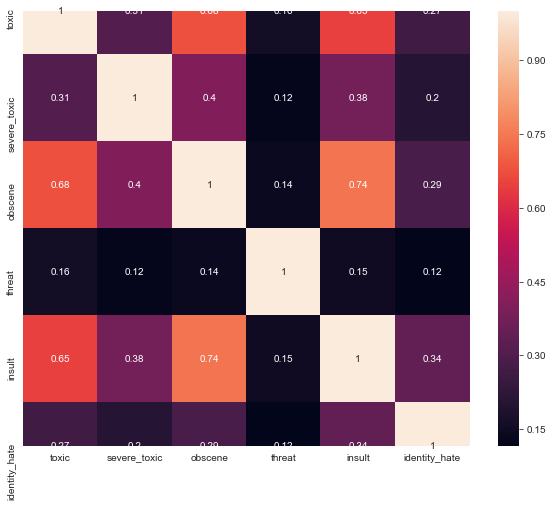

In [64]:
temp_df=train.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

## 1.2 Стратегия Влидации

Placeholder for validation stratagy explanation

## 1.3 Предобработка Данных 

In [2]:
MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

In [3]:
#load data
train_df = pd.read_csv('input/jigsaw-toxic-comment-classification-challenge' + '/train.csv', sep=',', header=0)
test_df = pd.read_csv('input/jigsaw-toxic-comment-classification-challenge' + '/test.csv', sep=',', header=0)
test_df = test_df.fillna('_NA_')

print("num train: ", train_df.shape[0])
print("num test: ", test_df.shape[0])

label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train_df[label_names].values

train_df['doc_len'] = train_df['comment_text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)

num train:  159571
num test:  153164


In [4]:
raw_docs_train = train_df['comment_text'].tolist()
raw_docs_test = test_df['comment_text'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")
processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
    
print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

pre-processing train data...


100%|███████████████████████████████████████████████████████████████████████| 153164/153164 [00:03<00:00, 44974.00it/s]


tokenizing input data...
dictionary size:  348520


# 2. Embeding

## 2.1 Applying

In [5]:
#model parameters
embed_dim = 300

EMBEDDING_FILE = 'input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'

# load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open(EMBEDDING_FILE, encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


2000005it [02:58, 11190.19it/s]


found 1999997 word vectors


In [6]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 22948


# 3. Models

## 3.1 CNN1D

### 3.1.1 Model

In [7]:
#training params
batch_size = 256 
num_epochs = 20 

#model parameters
num_filters = 64 
weight_decay = 1e-4

In [8]:
Xtrain, Xval, ytrain, yval = train_test_split(word_seq_train, y_train, train_size=0.90, random_state=233)

In [9]:
#CNN architecture
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 168, 300)          30000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 168, 64)           134464    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 84, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 84, 64)            28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)  

In [10]:
weight_path="output/simple_CNN_v1.h5"

reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                                   patience=3, verbose=1, mode='max',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-6)

best_w = keras.callbacks.ModelCheckpoint(weight_path,
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('output/checkpoint.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

callbacks = [best_w, last_w, reduceLROnPlat]

In [11]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

ra_val = RocAucEvaluation(validation_data=(Xval, yval), interval = 1)

callbacks.append(ra_val)

### 3.1.2 Training

In [12]:
#model training
hist = model.fit(Xtrain, 
                 ytrain,
                 batch_size=batch_size, 
                 epochs=num_epochs, 
                 callbacks=callbacks, 
                 validation_split=0.1,
                 shuffle=True, 
                 verbose=2)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 129251 samples, validate on 14362 samples
Epoch 1/20
 - 9s - loss: 0.0882 - acc: 0.9716 - val_loss: 0.0541 - val_acc: 0.9805

 ROC-AUC - epoch: 1 - score: 0.972789 

Epoch 2/20
 - 6s - loss: 0.0545 - acc: 0.9813 - val_loss: 0.0517 - val_acc: 0.9812

 ROC-AUC - epoch: 2 - score: 0.976364 

Epoch 3/20
 - 7s - loss: 0.0494 - acc: 0.9825 - val_loss: 0.0506 - val_acc: 0.9818

 ROC-AUC - epoch: 3 - score: 0.977120 

Epoch 4/20
 - 7s - loss: 0.0449 - acc: 0.9837 - val_loss: 0.0493 - val_acc: 0.9819

 ROC-AUC - epoch: 4 - score: 0.977366 

Epoch 5/20
 - 6s - loss: 0.0412 - acc: 0.9847 - val_loss: 0.0503 - val_acc: 0.9821

 ROC-AUC - epoch: 5 - score: 0.977087 

Epoch 6/20
 - 6s - loss: 0.0379 - acc: 0.9857 - val_loss: 0.0507 - val_acc: 0.9814

 ROC-AUC - epoch: 6 - score: 0.978445 

Epoch 7/20
 - 6s - loss: 0.0348 - acc: 0.9868 - val_loss: 0.0540 - val_acc: 0.9

### 3.1.3 Conclusion

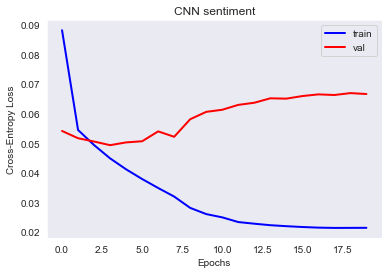

In [13]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

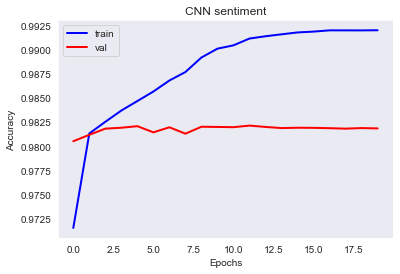

In [14]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [15]:
model.load_weights(weight_path)
y_test = model.predict(word_seq_test)

#create a submission
submission_df = pd.DataFrame(columns=['id'] + label_names)
submission_df['id'] = test_df['id'].values 
submission_df[label_names] = y_test 
submission_df.to_csv("submissions/cnn_fasttext_submission.csv", index=False)

<img src="https://i.ibb.co/2KsHzGR/2019-10-26-11-13-57.png" alt="Drawing" style="width: 1000px;"/>

## 3.2 LSTM

### 3.2.1 Model

In [16]:
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
               weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(LSTM(128, dropout=0.2))
model.add(Dense(ytrain.shape[1], activation='sigmoid'))


optimizer = keras.optimizers.RMSprop(lr=1e-3, decay=1e-4)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 168, 300)          30000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 30,220,422
Trainable params: 220,422
Non-trainable params: 30,000,000
_________________________________________________________________


In [17]:
lstm_weight_path="output/lstm_v1.h5"

reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                                   patience=3, verbose=1, mode='max',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-6)

best_w = keras.callbacks.ModelCheckpoint(lstm_weight_path,
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('output/checkpoint.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

callbacks = [best_w, last_w, reduceLROnPlat]

In [18]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

ra_val = RocAucEvaluation(validation_data=(Xval, yval), interval = 1)

callbacks.append(ra_val)

### 3.2.2 Training

In [19]:
#model training
hist = model.fit(Xtrain, 
                 ytrain,
                 batch_size=batch_size, 
                 epochs=20, 
                 callbacks=callbacks, 
                 validation_split=0.1,
                 shuffle=True, 
                 verbose=2)

Train on 129251 samples, validate on 14362 samples
Epoch 1/20
 - 107s - loss: 0.0670 - acc: 0.9771 - val_loss: 0.0519 - val_acc: 0.9811

 ROC-AUC - epoch: 1 - score: 0.976033 

Epoch 2/20
 - 106s - loss: 0.0471 - acc: 0.9822 - val_loss: 0.0444 - val_acc: 0.9826

 ROC-AUC - epoch: 2 - score: 0.982997 

Epoch 3/20
 - 107s - loss: 0.0442 - acc: 0.9830 - val_loss: 0.0435 - val_acc: 0.9828

 ROC-AUC - epoch: 3 - score: 0.984649 

Epoch 4/20
 - 106s - loss: 0.0419 - acc: 0.9837 - val_loss: 0.0421 - val_acc: 0.9835

 ROC-AUC - epoch: 4 - score: 0.985956 

Epoch 5/20
 - 106s - loss: 0.0403 - acc: 0.9841 - val_loss: 0.0413 - val_acc: 0.9838

 ROC-AUC - epoch: 5 - score: 0.986265 

Epoch 6/20
 - 106s - loss: 0.0388 - acc: 0.9847 - val_loss: 0.0417 - val_acc: 0.9840

 ROC-AUC - epoch: 6 - score: 0.986266 

Epoch 7/20
 - 106s - loss: 0.0376 - acc: 0.9851 - val_loss: 0.0412 - val_acc: 0.9840

 ROC-AUC - epoch: 7 - score: 0.986689 

Epoch 8/20
 - 106s - loss: 0.0364 - acc: 0.9856 - val_loss: 0.0404 

### 3.2.3 Conclusion

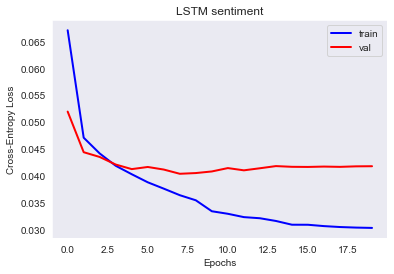

In [20]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

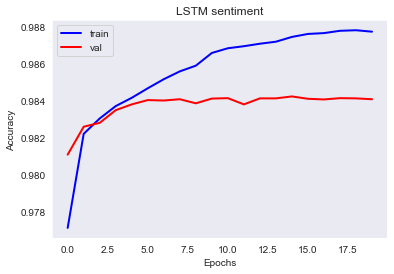

In [21]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [22]:
model.load_weights(lstm_weight_path)
y_test = model.predict(word_seq_test)

#create a submission
submission_df = pd.DataFrame(columns=['id'] + label_names)
submission_df['id'] = test_df['id'].values 
submission_df[label_names] = y_test 
submission_df.to_csv("submissions/lstm_fasttext_submission.csv", index=False)

<img src="https://i.ibb.co/CWvwrHx/2019-10-26-11-13-38.png" alt="Drawing" style="width: 1000px;"/>

## 3.3 Bi-LSTM

### 3.3.1 Model

In [23]:
# Bi-LSTM

model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Bidirectional(LSTM(64, dropout=0.2)))
model.add(Dense(ytrain.shape[1], activation='sigmoid'))

optimizer = keras.optimizers.RMSprop(lr=1e-3, decay=1e-4)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 168, 300)          30000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               186880    
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
Total params: 30,187,654
Trainable params: 187,654
Non-trainable params: 30,000,000
_________________________________________________________________


In [24]:
bilstm_weight_path="output/Bi-LSTM_v1.h5"

reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                                   patience=3, verbose=1, mode='max',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-6)

best_w = keras.callbacks.ModelCheckpoint(bilstm_weight_path,
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('output/checkpoint.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

callbacks = [best_w, last_w, reduceLROnPlat]

In [25]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

ra_val = RocAucEvaluation(validation_data=(Xval, yval), interval = 1)

callbacks.append(ra_val)

### 3.3.2 Training

In [26]:
#model training
hist = model.fit(Xtrain, 
                 ytrain,
                 batch_size=256, 
                 epochs=10, 
                 callbacks=callbacks, 
                 validation_split=0.1,
                 shuffle=True, 
                 verbose=2)

Train on 129251 samples, validate on 14362 samples
Epoch 1/10
 51968/129251 [===========>..................] - ETA: 12:39 - loss: 0.6878 - acc: 0.53 - ETA: 7:43 - loss: 0.6598 - acc: 0.7093 - ETA: 6:03 - loss: 0.6296 - acc: 0.791 - ETA: 5:14 - loss: 0.5949 - acc: 0.835 - ETA: 4:44 - loss: 0.5551 - acc: 0.862 - ETA: 4:24 - loss: 0.5155 - acc: 0.878 - ETA: 4:10 - loss: 0.4656 - acc: 0.891 - ETA: 4:00 - loss: 0.4212 - acc: 0.902 - ETA: 3:53 - loss: 0.3933 - acc: 0.908 - ETA: 3:47 - loss: 0.3683 - acc: 0.914 - ETA: 3:42 - loss: 0.3451 - acc: 0.919 - ETA: 3:37 - loss: 0.3323 - acc: 0.921 - ETA: 3:34 - loss: 0.3210 - acc: 0.924 - ETA: 3:31 - loss: 0.3073 - acc: 0.927 - ETA: 3:27 - loss: 0.2946 - acc: 0.930 - ETA: 3:25 - loss: 0.2847 - acc: 0.932 - ETA: 3:23 - loss: 0.2755 - acc: 0.934 - ETA: 3:20 - loss: 0.2688 - acc: 0.935 - ETA: 3:19 - loss: 0.2618 - acc: 0.936 - ETA: 3:17 - loss: 0.2552 - acc: 0.938 - ETA: 3:15 - loss: 0.2494 - acc: 0.939 - ETA: 3:14 - loss: 0.2431 - acc: 0.940 - ETA: 3:1

 52224/129251 [===========>..................] - ETA: 2:57 - loss: 0.0363 - acc: 0.987 - ETA: 2:54 - loss: 0.0587 - acc: 0.982 - ETA: 2:52 - loss: 0.0576 - acc: 0.981 - ETA: 2:51 - loss: 0.0594 - acc: 0.979 - ETA: 2:52 - loss: 0.0568 - acc: 0.980 - ETA: 2:51 - loss: 0.0577 - acc: 0.980 - ETA: 2:51 - loss: 0.0558 - acc: 0.980 - ETA: 2:51 - loss: 0.0558 - acc: 0.980 - ETA: 2:50 - loss: 0.0556 - acc: 0.980 - ETA: 2:49 - loss: 0.0555 - acc: 0.980 - ETA: 2:48 - loss: 0.0552 - acc: 0.980 - ETA: 2:48 - loss: 0.0553 - acc: 0.980 - ETA: 2:48 - loss: 0.0560 - acc: 0.980 - ETA: 2:48 - loss: 0.0555 - acc: 0.980 - ETA: 2:48 - loss: 0.0551 - acc: 0.980 - ETA: 2:47 - loss: 0.0542 - acc: 0.980 - ETA: 2:47 - loss: 0.0533 - acc: 0.981 - ETA: 2:47 - loss: 0.0536 - acc: 0.981 - ETA: 2:46 - loss: 0.0543 - acc: 0.980 - ETA: 2:46 - loss: 0.0550 - acc: 0.980 - ETA: 2:46 - loss: 0.0545 - acc: 0.980 - ETA: 2:46 - loss: 0.0543 - acc: 0.980 - ETA: 2:45 - loss: 0.0537 - acc: 0.980 - ETA: 2:46 - loss: 0.0534 - acc:

129251/129251 [==============================] - ETA: 31s - loss: 0.0489 - acc: 0.98 - ETA: 31s - loss: 0.0489 - acc: 0.98 - ETA: 31s - loss: 0.0489 - acc: 0.98 - ETA: 30s - loss: 0.0490 - acc: 0.98 - ETA: 30s - loss: 0.0490 - acc: 0.98 - ETA: 30s - loss: 0.0489 - acc: 0.98 - ETA: 29s - loss: 0.0489 - acc: 0.98 - ETA: 29s - loss: 0.0490 - acc: 0.98 - ETA: 29s - loss: 0.0489 - acc: 0.98 - ETA: 28s - loss: 0.0489 - acc: 0.98 - ETA: 28s - loss: 0.0489 - acc: 0.98 - ETA: 28s - loss: 0.0490 - acc: 0.98 - ETA: 27s - loss: 0.0489 - acc: 0.98 - ETA: 27s - loss: 0.0489 - acc: 0.98 - ETA: 27s - loss: 0.0489 - acc: 0.98 - ETA: 26s - loss: 0.0489 - acc: 0.98 - ETA: 26s - loss: 0.0489 - acc: 0.98 - ETA: 26s - loss: 0.0489 - acc: 0.98 - ETA: 25s - loss: 0.0489 - acc: 0.98 - ETA: 25s - loss: 0.0489 - acc: 0.98 - ETA: 24s - loss: 0.0489 - acc: 0.98 - ETA: 24s - loss: 0.0489 - acc: 0.98 - ETA: 24s - loss: 0.0489 - acc: 0.98 - ETA: 23s - loss: 0.0489 - acc: 0.98 - ETA: 23s - loss: 0.0488 - acc: 0.98 - E

 52224/129251 [===========>..................] - ETA: 2:52 - loss: 0.0424 - acc: 0.979 - ETA: 2:50 - loss: 0.0438 - acc: 0.979 - ETA: 2:51 - loss: 0.0423 - acc: 0.980 - ETA: 2:52 - loss: 0.0384 - acc: 0.982 - ETA: 2:52 - loss: 0.0392 - acc: 0.982 - ETA: 2:51 - loss: 0.0407 - acc: 0.981 - ETA: 2:51 - loss: 0.0425 - acc: 0.982 - ETA: 2:50 - loss: 0.0427 - acc: 0.982 - ETA: 2:52 - loss: 0.0430 - acc: 0.982 - ETA: 2:52 - loss: 0.0432 - acc: 0.982 - ETA: 2:52 - loss: 0.0436 - acc: 0.982 - ETA: 2:51 - loss: 0.0437 - acc: 0.982 - ETA: 2:50 - loss: 0.0430 - acc: 0.982 - ETA: 2:50 - loss: 0.0428 - acc: 0.983 - ETA: 2:49 - loss: 0.0422 - acc: 0.983 - ETA: 2:49 - loss: 0.0417 - acc: 0.983 - ETA: 2:49 - loss: 0.0417 - acc: 0.983 - ETA: 2:48 - loss: 0.0426 - acc: 0.982 - ETA: 2:47 - loss: 0.0424 - acc: 0.982 - ETA: 2:47 - loss: 0.0427 - acc: 0.982 - ETA: 2:47 - loss: 0.0431 - acc: 0.982 - ETA: 2:46 - loss: 0.0432 - acc: 0.982 - ETA: 2:46 - loss: 0.0432 - acc: 0.982 - ETA: 2:46 - loss: 0.0433 - acc:

129251/129251 [==============================] - ETA: 31s - loss: 0.0428 - acc: 0.98 - ETA: 31s - loss: 0.0428 - acc: 0.98 - ETA: 31s - loss: 0.0428 - acc: 0.98 - ETA: 30s - loss: 0.0428 - acc: 0.98 - ETA: 30s - loss: 0.0428 - acc: 0.98 - ETA: 30s - loss: 0.0428 - acc: 0.98 - ETA: 29s - loss: 0.0428 - acc: 0.98 - ETA: 29s - loss: 0.0427 - acc: 0.98 - ETA: 28s - loss: 0.0427 - acc: 0.98 - ETA: 28s - loss: 0.0427 - acc: 0.98 - ETA: 28s - loss: 0.0427 - acc: 0.98 - ETA: 27s - loss: 0.0427 - acc: 0.98 - ETA: 27s - loss: 0.0427 - acc: 0.98 - ETA: 27s - loss: 0.0427 - acc: 0.98 - ETA: 26s - loss: 0.0427 - acc: 0.98 - ETA: 26s - loss: 0.0427 - acc: 0.98 - ETA: 26s - loss: 0.0427 - acc: 0.98 - ETA: 25s - loss: 0.0427 - acc: 0.98 - ETA: 25s - loss: 0.0427 - acc: 0.98 - ETA: 25s - loss: 0.0427 - acc: 0.98 - ETA: 24s - loss: 0.0427 - acc: 0.98 - ETA: 24s - loss: 0.0427 - acc: 0.98 - ETA: 24s - loss: 0.0426 - acc: 0.98 - ETA: 23s - loss: 0.0426 - acc: 0.98 - ETA: 23s - loss: 0.0426 - acc: 0.98 - E

 52224/129251 [===========>..................] - ETA: 2:53 - loss: 0.0351 - acc: 0.988 - ETA: 2:54 - loss: 0.0397 - acc: 0.986 - ETA: 2:56 - loss: 0.0440 - acc: 0.982 - ETA: 2:54 - loss: 0.0456 - acc: 0.981 - ETA: 2:53 - loss: 0.0431 - acc: 0.983 - ETA: 2:53 - loss: 0.0408 - acc: 0.984 - ETA: 2:53 - loss: 0.0400 - acc: 0.984 - ETA: 2:53 - loss: 0.0415 - acc: 0.983 - ETA: 2:53 - loss: 0.0428 - acc: 0.982 - ETA: 2:52 - loss: 0.0424 - acc: 0.982 - ETA: 2:51 - loss: 0.0425 - acc: 0.983 - ETA: 2:50 - loss: 0.0426 - acc: 0.983 - ETA: 2:51 - loss: 0.0425 - acc: 0.983 - ETA: 2:50 - loss: 0.0420 - acc: 0.983 - ETA: 2:49 - loss: 0.0420 - acc: 0.983 - ETA: 2:49 - loss: 0.0424 - acc: 0.983 - ETA: 2:49 - loss: 0.0430 - acc: 0.983 - ETA: 2:48 - loss: 0.0429 - acc: 0.983 - ETA: 2:48 - loss: 0.0433 - acc: 0.983 - ETA: 2:48 - loss: 0.0426 - acc: 0.983 - ETA: 2:47 - loss: 0.0421 - acc: 0.983 - ETA: 2:47 - loss: 0.0417 - acc: 0.983 - ETA: 2:47 - loss: 0.0418 - acc: 0.983 - ETA: 2:46 - loss: 0.0417 - acc:

129251/129251 [==============================] - ETA: 31s - loss: 0.0402 - acc: 0.98 - ETA: 31s - loss: 0.0402 - acc: 0.98 - ETA: 30s - loss: 0.0402 - acc: 0.98 - ETA: 30s - loss: 0.0402 - acc: 0.98 - ETA: 30s - loss: 0.0402 - acc: 0.98 - ETA: 29s - loss: 0.0401 - acc: 0.98 - ETA: 29s - loss: 0.0402 - acc: 0.98 - ETA: 29s - loss: 0.0402 - acc: 0.98 - ETA: 28s - loss: 0.0402 - acc: 0.98 - ETA: 28s - loss: 0.0402 - acc: 0.98 - ETA: 28s - loss: 0.0402 - acc: 0.98 - ETA: 27s - loss: 0.0402 - acc: 0.98 - ETA: 27s - loss: 0.0402 - acc: 0.98 - ETA: 27s - loss: 0.0402 - acc: 0.98 - ETA: 26s - loss: 0.0402 - acc: 0.98 - ETA: 26s - loss: 0.0402 - acc: 0.98 - ETA: 26s - loss: 0.0402 - acc: 0.98 - ETA: 25s - loss: 0.0402 - acc: 0.98 - ETA: 25s - loss: 0.0402 - acc: 0.98 - ETA: 25s - loss: 0.0402 - acc: 0.98 - ETA: 24s - loss: 0.0402 - acc: 0.98 - ETA: 24s - loss: 0.0402 - acc: 0.98 - ETA: 24s - loss: 0.0402 - acc: 0.98 - ETA: 23s - loss: 0.0402 - acc: 0.98 - ETA: 23s - loss: 0.0402 - acc: 0.98 - E

 52224/129251 [===========>..................] - ETA: 2:43 - loss: 0.0506 - acc: 0.982 - ETA: 2:50 - loss: 0.0431 - acc: 0.985 - ETA: 2:46 - loss: 0.0412 - acc: 0.985 - ETA: 2:52 - loss: 0.0376 - acc: 0.986 - ETA: 2:55 - loss: 0.0396 - acc: 0.984 - ETA: 2:52 - loss: 0.0401 - acc: 0.984 - ETA: 2:50 - loss: 0.0376 - acc: 0.985 - ETA: 2:51 - loss: 0.0380 - acc: 0.985 - ETA: 2:50 - loss: 0.0393 - acc: 0.984 - ETA: 2:48 - loss: 0.0398 - acc: 0.984 - ETA: 2:47 - loss: 0.0402 - acc: 0.984 - ETA: 2:46 - loss: 0.0397 - acc: 0.984 - ETA: 2:46 - loss: 0.0391 - acc: 0.984 - ETA: 2:45 - loss: 0.0382 - acc: 0.984 - ETA: 2:44 - loss: 0.0385 - acc: 0.984 - ETA: 2:44 - loss: 0.0389 - acc: 0.984 - ETA: 2:43 - loss: 0.0386 - acc: 0.984 - ETA: 2:42 - loss: 0.0385 - acc: 0.984 - ETA: 2:42 - loss: 0.0383 - acc: 0.984 - ETA: 2:41 - loss: 0.0385 - acc: 0.984 - ETA: 2:41 - loss: 0.0380 - acc: 0.984 - ETA: 2:40 - loss: 0.0382 - acc: 0.984 - ETA: 2:41 - loss: 0.0383 - acc: 0.984 - ETA: 2:41 - loss: 0.0376 - acc:

129251/129251 [==============================] - ETA: 30s - loss: 0.0381 - acc: 0.98 - ETA: 30s - loss: 0.0381 - acc: 0.98 - ETA: 30s - loss: 0.0381 - acc: 0.98 - ETA: 29s - loss: 0.0381 - acc: 0.98 - ETA: 29s - loss: 0.0381 - acc: 0.98 - ETA: 29s - loss: 0.0381 - acc: 0.98 - ETA: 28s - loss: 0.0381 - acc: 0.98 - ETA: 28s - loss: 0.0381 - acc: 0.98 - ETA: 28s - loss: 0.0381 - acc: 0.98 - ETA: 27s - loss: 0.0381 - acc: 0.98 - ETA: 27s - loss: 0.0381 - acc: 0.98 - ETA: 27s - loss: 0.0381 - acc: 0.98 - ETA: 26s - loss: 0.0381 - acc: 0.98 - ETA: 26s - loss: 0.0381 - acc: 0.98 - ETA: 26s - loss: 0.0381 - acc: 0.98 - ETA: 25s - loss: 0.0381 - acc: 0.98 - ETA: 25s - loss: 0.0381 - acc: 0.98 - ETA: 25s - loss: 0.0381 - acc: 0.98 - ETA: 24s - loss: 0.0382 - acc: 0.98 - ETA: 24s - loss: 0.0382 - acc: 0.98 - ETA: 24s - loss: 0.0382 - acc: 0.98 - ETA: 23s - loss: 0.0382 - acc: 0.98 - ETA: 23s - loss: 0.0382 - acc: 0.98 - ETA: 23s - loss: 0.0381 - acc: 0.98 - ETA: 22s - loss: 0.0381 - acc: 0.98 - E

 52224/129251 [===========>..................] - ETA: 2:47 - loss: 0.0342 - acc: 0.984 - ETA: 2:44 - loss: 0.0366 - acc: 0.982 - ETA: 2:48 - loss: 0.0349 - acc: 0.983 - ETA: 2:46 - loss: 0.0346 - acc: 0.985 - ETA: 2:48 - loss: 0.0364 - acc: 0.984 - ETA: 2:47 - loss: 0.0372 - acc: 0.984 - ETA: 2:45 - loss: 0.0376 - acc: 0.984 - ETA: 2:45 - loss: 0.0366 - acc: 0.984 - ETA: 2:44 - loss: 0.0358 - acc: 0.985 - ETA: 2:43 - loss: 0.0371 - acc: 0.984 - ETA: 2:43 - loss: 0.0361 - acc: 0.985 - ETA: 2:42 - loss: 0.0358 - acc: 0.985 - ETA: 2:42 - loss: 0.0350 - acc: 0.985 - ETA: 2:41 - loss: 0.0349 - acc: 0.985 - ETA: 2:41 - loss: 0.0346 - acc: 0.985 - ETA: 2:40 - loss: 0.0345 - acc: 0.985 - ETA: 2:40 - loss: 0.0348 - acc: 0.986 - ETA: 2:40 - loss: 0.0350 - acc: 0.986 - ETA: 2:39 - loss: 0.0351 - acc: 0.985 - ETA: 2:39 - loss: 0.0351 - acc: 0.985 - ETA: 2:39 - loss: 0.0348 - acc: 0.986 - ETA: 2:39 - loss: 0.0353 - acc: 0.985 - ETA: 2:39 - loss: 0.0350 - acc: 0.985 - ETA: 2:39 - loss: 0.0346 - acc:

129251/129251 [==============================] - ETA: 30s - loss: 0.0368 - acc: 0.98 - ETA: 30s - loss: 0.0368 - acc: 0.98 - ETA: 30s - loss: 0.0368 - acc: 0.98 - ETA: 29s - loss: 0.0368 - acc: 0.98 - ETA: 29s - loss: 0.0368 - acc: 0.98 - ETA: 28s - loss: 0.0368 - acc: 0.98 - ETA: 28s - loss: 0.0368 - acc: 0.98 - ETA: 28s - loss: 0.0368 - acc: 0.98 - ETA: 27s - loss: 0.0368 - acc: 0.98 - ETA: 27s - loss: 0.0368 - acc: 0.98 - ETA: 27s - loss: 0.0368 - acc: 0.98 - ETA: 27s - loss: 0.0369 - acc: 0.98 - ETA: 26s - loss: 0.0368 - acc: 0.98 - ETA: 26s - loss: 0.0369 - acc: 0.98 - ETA: 26s - loss: 0.0368 - acc: 0.98 - ETA: 25s - loss: 0.0368 - acc: 0.98 - ETA: 25s - loss: 0.0368 - acc: 0.98 - ETA: 25s - loss: 0.0369 - acc: 0.98 - ETA: 24s - loss: 0.0369 - acc: 0.98 - ETA: 24s - loss: 0.0368 - acc: 0.98 - ETA: 24s - loss: 0.0368 - acc: 0.98 - ETA: 23s - loss: 0.0368 - acc: 0.98 - ETA: 23s - loss: 0.0368 - acc: 0.98 - ETA: 22s - loss: 0.0368 - acc: 0.98 - ETA: 22s - loss: 0.0368 - acc: 0.98 - E

### 3.3.3 Conclusion

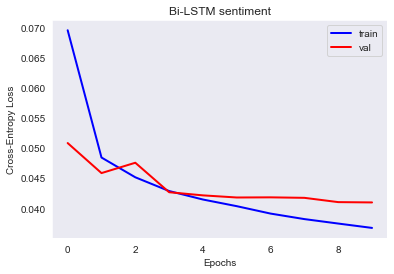

In [27]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('Bi-LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

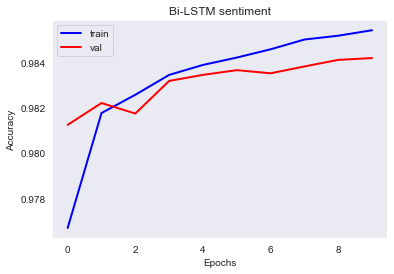

In [28]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('Bi-LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [29]:
model.load_weights(bilstm_weight_path)
y_test = model.predict(word_seq_test)

#create a submission
submission_df = pd.DataFrame(columns=['id'] + label_names)
submission_df['id'] = test_df['id'].values 
submission_df[label_names] = y_test 
submission_df.to_csv("submissions/bilstm_fasttext_submission.csv", index=False)

<img src="https://i.ibb.co/F3XB3R0/2019-10-26-11-13-46.png" alt="Drawing" style="width: 1000px;"/>

## 4. BERT

### 4.1 Model Prepearing

In [30]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

import tensorflow as tf

In [31]:
SEQ_LEN = 64
BATCH_SIZE = 128
EPOCHS = 1
LR = 1e-4

pretrained_path = 'input/uncased_l-12_h-768_a-12/uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = 'comment_text'
LABEL_COLUMN = 'target'

In [32]:
token_dict = load_vocabulary(vocab_path)
tokenizer = Tokenizer(token_dict)

In [33]:
# Load and Convert to data that BERT understand

def convert_data(data_df):
    global tokenizer
    indices, targets = [], []
    label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        targets.append(data_df[label_names].iloc[i].values)
    items = list(zip(indices, targets))
    np.random.shuffle(items)
    indices, targets = zip(*items)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)], np.array(targets)

In [34]:
def load_data(path):
    data_df = pd.read_csv(path, nrows=10000)
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x, data_y = convert_data(data_df)
    return data_x, data_y

In [35]:
train_x, train_y = load_data('input/jigsaw-toxic-comment-classification-challenge/train.csv')
gc.collect()

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 701.44it/s]


5249

In [36]:
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,
)

In [37]:
inputs = model.inputs[:2]
dense = model.layers[-3].output
outputs = keras.layers.Dense(6, activation='sigmoid', kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                             name = 'real_output')(dense)

decay_steps, warmup_steps = calc_train_steps(
    train_y.shape[0],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

model = keras.models.Model(inputs, outputs)
model.compile(
    AdamWarmup(decay_steps=decay_steps, warmup_steps=warmup_steps, lr=LR),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 64)           0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 64)           0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 64, 768), (3 23440896    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 64, 768)      1536        Input-Segment[0][0]              
__________________________________________________________________________________________________
Embedding-

Encoder-9-MultiHeadSelfAttentio (None, 64, 768)      2362368     Encoder-8-FeedForward-Norm[0][0] 
__________________________________________________________________________________________________
Encoder-9-MultiHeadSelfAttentio (None, 64, 768)      0           Encoder-9-MultiHeadSelfAttention[
__________________________________________________________________________________________________
Encoder-9-MultiHeadSelfAttentio (None, 64, 768)      0           Encoder-8-FeedForward-Norm[0][0] 
                                                                 Encoder-9-MultiHeadSelfAttention-
__________________________________________________________________________________________________
Encoder-9-MultiHeadSelfAttentio (None, 64, 768)      1536        Encoder-9-MultiHeadSelfAttention-
__________________________________________________________________________________________________
Encoder-9-FeedForward (FeedForw (None, 64, 768)      4722432     Encoder-9-MultiHeadSelfAttention-
__________

In [39]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init_op = tf.variables_initializer(
    [v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables]
)
sess.run(init_op)

### 4.2 Training

In [40]:
bert_weight_path="output/bert.h5"

reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                                   patience=3, verbose=1, mode='max',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-6)

best_w = keras.callbacks.ModelCheckpoint(bert_weight_path,
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('output/checkpoint.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

callbacks = [best_w, last_w, reduceLROnPlat]

In [41]:
#model training
hist = model.fit(train_x, 
                 train_y,
                 batch_size=32, 
                 epochs=5, 
                 callbacks=callbacks, 
                 validation_split=0.1,
                 shuffle=True, 
                 verbose=2)

Train on 9000 samples, validate on 1000 samples
Epoch 1/5
 - 125s - loss: 0.1440 - acc: 0.9548 - val_loss: 0.1140 - val_acc: 0.9660
Epoch 2/5
 - 110s - loss: 0.1176 - acc: 0.9643 - val_loss: 0.1140 - val_acc: 0.9660
Epoch 3/5
 - 111s - loss: 0.1176 - acc: 0.9644 - val_loss: 0.1140 - val_acc: 0.9660
Epoch 4/5
 - 111s - loss: 0.1175 - acc: 0.9645 - val_loss: 0.1140 - val_acc: 0.9660

Epoch 00004: ReduceLROnPlateau reducing learning rate to 3.2999999166349884e-05.
Epoch 5/5
 - 111s - loss: 0.1176 - acc: 0.9644 - val_loss: 0.1140 - val_acc: 0.9660


### 4.3 Conclusion

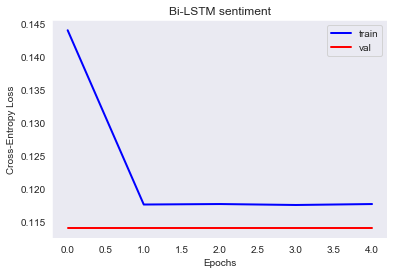

In [42]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('Bi-LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

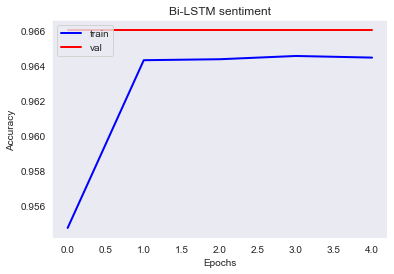

In [43]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('Bi-LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [44]:
def convert_test(test_df):
    global tokenizer
    indices = []
    for i in tqdm(range(len(test_df))):
        ids, segments = tokenizer.encode(test_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def load_test(path):
    data_df = pd.read_csv(path)
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x = convert_test(data_df)
    return data_x

In [45]:
test_x = load_test('input/jigsaw-toxic-comment-classification-challenge/test.csv')
gc.collect()

100%|████████████████████████████████████████████████████████████████████████| 153164/153164 [02:04<00:00, 1229.07it/s]


5653

In [46]:
prediction = model.predict(test_x)

In [47]:
label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
test_df = pd.read_csv('input/jigsaw-toxic-comment-classification-challenge' + '/test.csv', sep=',', header=0)
test_df = test_df.fillna('_NA_')

submission_df = pd.DataFrame(columns=['id'] + label_names)
submission_df['id'] = test_df['id'].values 
submission_df[label_names] = prediction 
submission_df.to_csv("submissions/bert_submission.csv", index=False)

<img src="https://i.ibb.co/RBKxZPf/2019-10-26-11-14-07.png" alt="Drawing" style="width: 1000px;"/>

## 5. Try Hard

In [7]:
BATCH_SIZE = 512
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
EPOCHS = 10
MAX_LEN = 220

In [8]:
Xtrain, Xval, ytrain, yval = train_test_split(word_seq_train, y_train, train_size=0.90, random_state=233)

In [9]:
def build_model(embedding_matrix):
    words = Input(shape=(None,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(CuDNNGRU(LSTM_UNITS, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)

    hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    result = Dense(6, activation='sigmoid')(hidden)
    
    
    model = Model(inputs=words, outputs=result)
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model

In [10]:
model = build_model(embedding_matrix)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    30000000    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, None, 300)    0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidi

In [11]:
bi_gru_lstm_weight_path="output/Bi-GRU-LSTM_v1.h5"

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=3, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-6)

best_w = keras.callbacks.ModelCheckpoint(bi_gru_lstm_weight_path,
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('output/checkpoint.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

callbacks = [best_w, last_w, reduceLROnPlat]

In [12]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

ra_val = RocAucEvaluation(validation_data=(Xval, yval), interval = 1)

callbacks.append(ra_val)

In [13]:
EPOCHS = 5
SEEDS = 10

pred = 0

for ii in range(SEEDS):
    print(f'Fold {ii}/{SEEDS}')
    model = build_model(embedding_matrix)
    for global_epoch in range(EPOCHS):
        print(f'Epoch {global_epoch}/{EPOCHS}')
        model.fit(
                    Xtrain,
                    ytrain,
                    validation_split=0.1,
                    batch_size=128,
                    epochs=1,
                    verbose=2,
                    callbacks=[
                        LearningRateScheduler(lambda _: 1e-3 * (0.5 ** global_epoch)),
                        RocAucEvaluation(validation_data=(Xval, yval), interval=1),
                        best_w,
                    ]
                )

    pred += model.predict(word_seq_test, batch_size=1024, verbose=2) / SEEDS
    np.save('pred', pred)

Fold 0/10
Epoch 0/5
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 129251 samples, validate on 14362 samples
Epoch 1/1
 - 48s - loss: 0.0527 - val_loss: 0.0446

 ROC-AUC - epoch: 1 - score: 0.984312 

Epoch 1/5
Train on 129251 samples, validate on 14362 samples
Epoch 1/1
 - 47s - loss: 0.0416 - val_loss: 0.0403

 ROC-AUC - epoch: 1 - score: 0.987101 

Epoch 2/5
Train on 129251 samples, validate on 14362 samples
Epoch 1/1
 - 48s - loss: 0.0384 - val_loss: 0.0402

 ROC-AUC - epoch: 1 - score: 0.987850 

Epoch 3/5
Train on 129251 samples, validate on 14362 samples
Epoch 1/1
 - 48s - loss: 0.0365 - val_loss: 0.0397

 ROC-AUC - epoch: 1 - score: 0.988246 

Epoch 4/5
Train on 129251 samples, validate on 14362 samples
Epoch 1/1
 - 48s - loss: 0.0351 - val_loss: 0.0394

 ROC-AUC - epoch: 1 - score: 0.988248 

Fold 1/10
Epoch 0/5
Train on 129251 samples, validate on 14362 samples
Epoch 1/1
 - 49s - loss: 0.0

Epoch 1/1
 - 48s - loss: 0.0350 - val_loss: 0.0397

 ROC-AUC - epoch: 1 - score: 0.988674 



In [35]:
label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

#create a submission
submission_df = pd.DataFrame(columns=['id'] + label_names)
submission_df['id'] = test_df['id'].values 
submission_df[label_names] = pred 
submission_df.to_csv("submissions/bi_gru_lstm_fasttext_submission.csv", index=False)

<img src="https://i.ibb.co/TbV28PH/2019-10-26-13-45-12.png" alt="Drawing" style="width: 1000px;"/>